## Diffusion as composite of Fick's law and mass conservation

In [1]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Graphics, Catlab.Programs
using CombinatorialSpaces.ExteriorCalculus

@present DiffusionSpace2D(FreeExtCalc2D) begin
  X::Space
  k::Hom(Form1(X), Form1(X)) # diffusivity of space, usually constant (scalar multiplication)
end

FicksLaw2D = @free_diagram DiffusionSpace2D begin
  C::Form0{X}
  dC::Form1{X}
  J::DualForm1{X}

  dC == d₀{X}(C)
  J == ⋆₁{X}(k(dC))
end

DiffusionConservation2D = @free_diagram DiffusionSpace2D begin
  (C, Ċ)::Form0{X}
  ϕ::DualForm1{X}
  dϕ::DualForm2{X}

  dϕ == dual_d₁{X}(ϕ)
  Ċ == ∂ₜ{Form0{X}}(C)
  Ċ == ⋆₀⁻¹{X}(dϕ)
end;

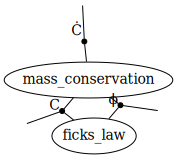

In [2]:
compose_diffusion = @relation (C, Ċ, ϕ) begin
  ficks_law(C, ϕ)
  mass_conservation(C, Ċ, ϕ)
end

to_graphviz(compose_diffusion, box_labels=:name, junction_labels=:variable,
            graph_attrs=Dict(:start => "2"))

In [3]:
using Decapods.OpenDiagrams

composed_diffusion = oapply(compose_diffusion, [
    OpenDiagram(FicksLaw2D, [:C, :J]),
    OpenDiagram(DiffusionConservation2D, [:C, :Ċ, :ϕ]),
]);

Compare composite diagram with explicitly constructed diagram.

In [4]:
using Test

Diffusion2D = @free_diagram DiffusionSpace2D begin
  (C, Ċ)::Form0{X}
  dC::Form1{X}
  ϕ::DualForm1{X}
  dϕ::DualForm2{X}

  Ċ == ∂ₜ{Form0{X}}(C)
  dC == d₀{X}(C)
  ϕ == ⋆₁{X}(k(dC))
  dϕ == dual_d₁{X}(ϕ)
  Ċ == ⋆₀⁻¹{X}(dϕ)
end

ComposedDiffusion2D = apex(composed_diffusion)
f = isomorphism(graph(dom(ComposedDiffusion2D)), graph(dom(Diffusion2D)))
@test !isnothing(f)
F = FinFunctor(map(collect, components(f)), dom(ComposedDiffusion2D), dom(Diffusion2D))
@test ComposedDiffusion2D == compose(F, Diffusion2D)

Test Passed